In [4]:
# Grafica las curvas IDT.

import pandas as pd
import xarray as xr

from scipy import stats

from matplotlib import pyplot as plt

In [5]:
i = 0

name = [ "CHIRPS_comp", "CHIRPS_megalopolis", "prec_hist_comp_CHIRPS",
    "prec_hist_comp_estaciones", "prec_hist_hist" ]


path_gev = "../results/" + name[i] + "/" + name[i] + "_idf_gev.nc"
path_val = "../results/" + name[i] + "/" + name[i] + "_idf_valores.nc" 
path_ret = "../results/" + name[i] + "/" + name[i] + "_tretorno.nc" 

ds_gev = xr.open_dataset(path_gev)
ds_val = xr.open_dataset(path_val)
ds_ret = xr.open_dataset(path_ret).drop( ["AÑO", "PROBABILIDAD"] )

# W: número de longitud.
# N: número de latitud.
# D: duración.
# T: tiempo de retorno.
W = 8
N = 8
D = 4   # [horas]
T = 200 # [años ]

In [6]:
# Utilizar información medida o calculada con distribución.
#RET = True
RET = False
if RET:
    ds_i = ds_ret
    ret = "valores medidos"
else:
    ds_i = ds_val
    ret = "distribución GEV"

# Utilizar unidades de precipitación o de intensidad.
PRE = True
#PRE = False
pre   = "mm"
p_esp = ""
if PRE:
    p_name = "Precipitación"
    p_D = D
else:
    p_name = "Intensidad"
    pre   += "/h"
    p_esp += "   "
    p_D      = 1

LON = ds_i["LONGITUD"].isel( LONGITUD = W ).values
LAT = ds_i["LATITUD" ].isel( LATITUD  = N ).values

In [7]:
# Calcula una intensidad con la distribución GEV.

param = ds_gev.isel( {"LONGITUD": W, "LATITUD": N}
    ).to_dataframe().loc[D]
GEV = stats.genextreme(*param.iloc[0:3])

print("Intensidad de precipitación obtenida con distribución GEV")
print( f"Ubicación        : {LAT:.3f}°N  {LON:.3f}°W" )
print( f"Duración         : {D:5.2f} horas" )
print( f"Tiempo de retorno: {T:4d}  años" )
print( f"{p_name}{p_esp}    : {( GEV.isf(1/T) * p_D ):5.1f} {pre}" )
print( f"Ktest pvalue     : {param.iloc[3]:.3f}" )

Intensidad de precipitación obtenida con distribución GEV
Ubicación        : 18.575°N  -100.025°W
Duración         :  4.00 horas
Tiempo de retorno:  200  años
Precipitación    : -400.1 mm
Ktest pvalue     : 17.554


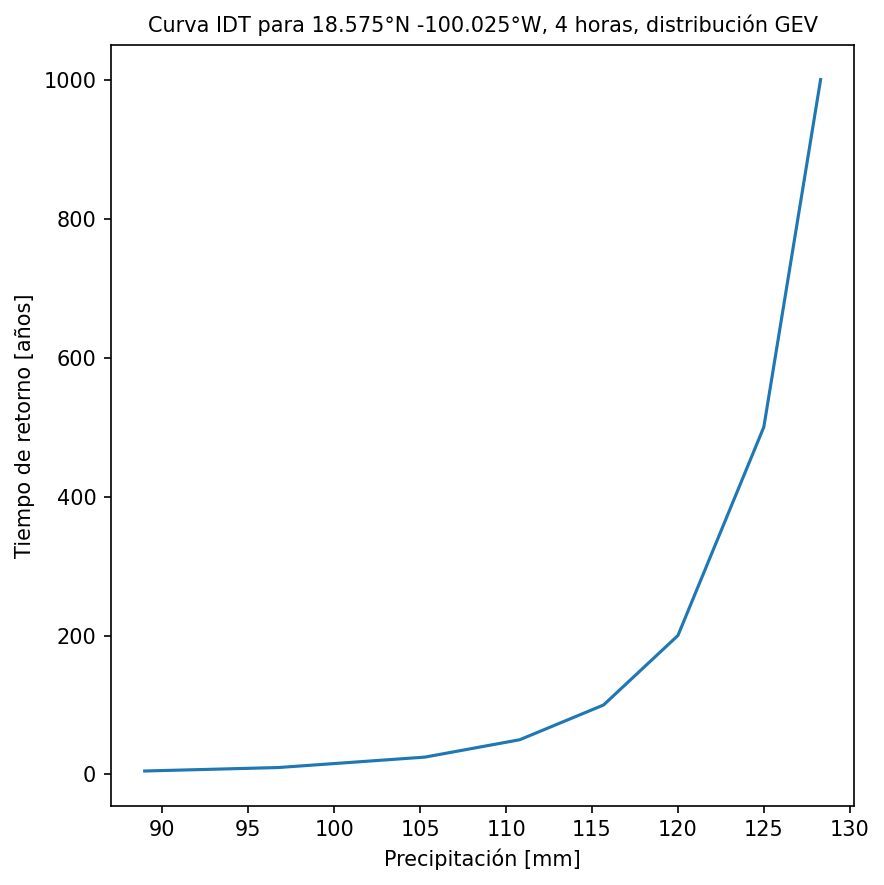

In [8]:
# Graficar una sola duración.

df_i_dur = ds_i.isel( {"LONGITUD": W, "LATITUD": N}
    ).sel( {"DURACION": D} ).to_dataframe()

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Declaramos variables.
x = df_i_dur["INTENSIDAD"] * p_D
y = df_i_dur.index

# Graficamos.
ax.plot(x, y)

# Estilo.
# Nombre de ejes.
ax.set_xlabel(f"{p_name} [{pre}]")
ax.set_ylabel("Tiempo de retorno [años]")
# Título.
ax.set_title( f"Curva IDT para {LAT:.3f}°N {LON:.3f}°W, {D} horas, {ret}",
    size = 10 )

fig.tight_layout()
plt.show()

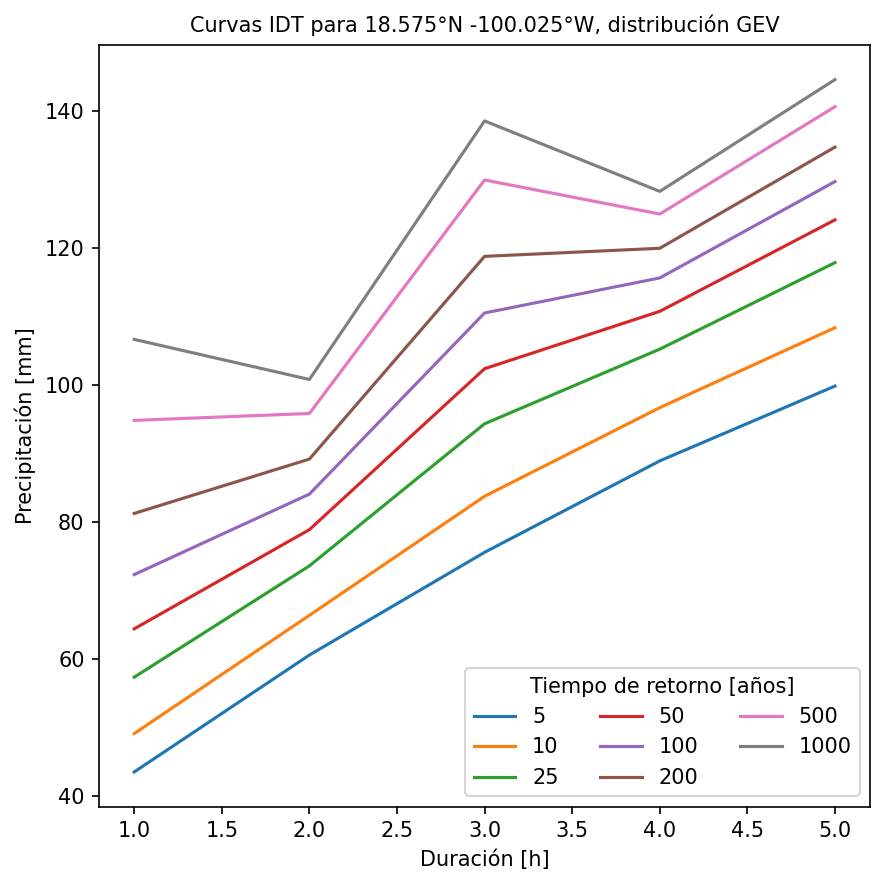

In [9]:
# Graficar todas las duraciones.

# Cantidad de tiempos de retorno a saltarse.
if RET: S = 3
else  : S = 1 

df_i = ds_i.isel( {"LONGITUD": W, "LATITUD": N} ).to_dataframe()
df_i = df_i.unstack( level = 1 )["INTENSIDAD"]
if RET: df_i.columns = [f"{x:.2f}" for x in df_i.columns]
else: df_i.columns = df_i.columns.astype(int)

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
if PRE:
    df_i.loc[:, :] = ( df_i.values.transpose()
        * df_i.index.values ).transpose()
ax.plot(df_i.loc[:, ::S])

# Estilo.
# Nombre de ejes.
ax.set_xlabel("Duración [h]")
ax.set_ylabel(f"{p_name} [{pre}]")
# Leyendas.
ax.legend(df_i.columns[::S], title = "Tiempo de retorno [años]", ncol = 3)
# Título.
ax.set_title(f"Curvas IDT para {LAT:.3f}°N {LON:.3f}°W, {ret}", size = 10)

fig.tight_layout()
plt.show()